In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score
import itertools

In [2]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.9/212.9 kB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 kB 5.0 MB/s eta 0:00:00


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/validation/smoteX_kcbert/kcbert_subset1_logit_test.pkl

### Pi

In [10]:
pi_values = []
for i in range(5):
  pi = pd.read_csv(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/ETRI_2023_AI_KCC/dataset/KFold/Subset{i+1}.csv')
  pi_value = pi['Emotion_p_i']
  pi_values.append(pi_value)

In [12]:
pi_values[1]

0       0.288889
1       0.533333
2       0.800000
3       0.800000
4       0.311111
          ...   
3055    0.800000
3056    0.488889
3057    0.800000
3058    1.000000
3059    1.000000
Name: Emotion_p_i, Length: 3060, dtype: float64

### Loading NLP & Wav Logits

In [5]:
nlp_wav_logits = []
true_labels = []
for i in range(5):
  nlp_logit = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/ETRI_2023_AI_KCC/dataset/Fusion(text)/late/kcbert_subset{i+1}_logit_test.pkl')
  wav_logit = pd.read_pickle(f'/content/drive/MyDrive/Colab Notebooks/2023 휴먼이해 공모전/ETRI_2023_AI_KCC/dataset/Fusion(wav)/late/late{i+1}.pkl')

  for idx, row in nlp_logit.iterrows():
    if idx == 0:
      nlp_feature_array_train = nlp_logit.loc[idx, 'logit_value']
    else:
      new_array_train = nlp_logit.loc[idx, 'logit_value']
      nlp_feature_array_train = np.vstack([nlp_feature_array_train, new_array_train])
  nlp_train_df = pd.DataFrame(nlp_feature_array_train)

  for idx, row in wav_logit.iterrows():
    if idx == 0:
      wav_feature_array_train = wav_logit.loc[idx, 'logits']
    else:
      wav_new_array_train = wav_logit.loc[idx, 'logits']
      wav_feature_array_train = np.vstack([wav_feature_array_train, wav_new_array_train])
  wav_train_df = pd.DataFrame(wav_feature_array_train)

  nlp_wav_logits.append((nlp_train_df,wav_train_df))
  true_labels.append((nlp_logit['Emotion_x'], wav_logit['Emotion']))

In [7]:
type(nlp_wav_logits[0])

tuple

In [13]:
true_labels[0][0]

0          fear
1          fear
2          fear
3          fear
4          fear
         ...   
3055    neutral
3056    neutral
3057    neutral
3058    neutral
3059    neutral
Name: Emotion_x, Length: 3060, dtype: object

In [14]:
nlp_wav_logits[0][0]

,0,1,2,3,4,5,6
0,0.010788,0.004384,0.719553,0.008526,0.009741,0.005013,0.241996
1,0.015114,0.014388,0.257702,0.020166,0.037385,0.001295,0.653950
2,0.379023,0.013638,0.399965,0.008043,0.021507,0.003232,0.174592
3,0.024273,0.013306,0.828237,0.039121,0.010829,0.004753,0.079480
4,0.047157,0.013190,0.788468,0.019085,0.016453,0.014676,0.100973
...,...,...,...,...,...,...,...
3055,0.014104,0.015191,0.014682,0.259793,0.434125,0.006823,0.255282
3056,0.003743,0.002124,0.003095,0.084102,0.860107,0.004893,0.041935
3057,0.006036,0.001729,0.003977,0.138130,0.824101,0.017307,0.008720
3058,0.003937,0.001211,0.005424,0.050407,0.920055,0.001788,0.017178


In [223]:
nlp_probs=nlp_wav_logits[4][0]
wav_probs=nlp_wav_logits[4][1]

In [224]:
emotion_label=true_labels[4][0]

In [205]:
emotion_label

0          fear
1          fear
2          fear
3          fear
4          fear
         ...   
3054    neutral
3055    neutral
3056    neutral
3057    neutral
3058    neutral
Name: Emotion_x, Length: 3059, dtype: object

In [225]:
nlp_probs = nlp_probs.to_numpy()
wav_probs = wav_probs.to_numpy()

In [226]:
emotion_dict = {'angry': 0,
                'disgust': 1,
                'fear': 2,
                'happy': 3,
                'neutral': 4,
                'sad': 5,
                'surprise': 6}

In [227]:
vec_func = np.vectorize(lambda x:emotion_dict[x])
emotion_encoded = vec_func(emotion_label)

In [228]:
import optuna

In [229]:
def objective(trial):
    # 변수 정의
    w1 = trial.suggest_uniform('w1', 0, 1)
    w2 = 1 - w1

    # 가중합 계산
    p = w1 * nlp_probs + w2 * wav_probs

    # 분류 결과
    y_pred = np.argmax(p, axis=1)

    # F1-Score
    f1 = f1_score(y_pred, emotion_encoded, average='macro')

    # 정확도 계산
    accuracy = np.mean(y_pred == emotion_encoded)

    # 목적 함수값
    return -f1

In [230]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    #print(pred)
    pred = [id_to_emotion[num] for num in pred]
    print(y_test,pred)
    #one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.4f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.4f}'.format(f1_score(y_test, pred, average='macro')))
    print('Test Set Precision =  {0:.4f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.4f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

In [212]:
y_preds = []

In [ ]:
for i in range(5):
  nlp_probs=nlp_wav_logits[i][0]
  wav_probs=nlp_wav_logits[i][1]
  nlp_probs = nlp_probs.to_numpy()
  wav_probs = wav_probs.to_numpy()
  vec_func = np.vectorize(lambda x:emotion_dict[x])
  emotion_encoded = vec_func(emotion_label)
  study = optuna.create_study(direction='minimize')
  study.optimize(objective, n_trials=300)

  nlp_weight = study.best_params['w1']
  wav_weight = 1 - nlp_weight
  print('==========Optimized weights==========')
  print(f'NLP : {nlp_weight}\nWav : {wav_weight}')

  probs = nlp_weight * nlp_probs + wav_weight * wav_probs
  y_pred_optuna = np.argmax(probs, axis=1)
  y_preds.append(y_pred_optuna)

In [231]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=300)

nlp_weight = study.best_params['w1']
wav_weight = 1 - nlp_weight
print('==========Optimized weights==========')
print(f'NLP : {nlp_weight}\nWav : {wav_weight}')

[I 2023-04-30 07:58:34,342] A new study created in memory with name: no-name-7846f333-d858-46d0-8957-02eb959b334a
<ipython-input-229-9808f0386bf7>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 07:58:34,351] Trial 0 finished with value: -0.4358557190564099 and parameters: {'w1': 0.9601344250495646}. Best is trial 0 with value: -0.4358557190564099.
<ipython-input-229-9808f0386bf7>:3: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  w1 = trial.suggest_uniform('w1', 0, 1)
[I 2023-04-30 07:58:34,358] Trial 1 finished with value: -0.45622702580723595 and parameters: {'w1': 0.6592417279993766}. Best is tr

==========Optimized weights==========
NLP : 0.4614497221404479
Wav : 0.5385502778595521


In [232]:
probs = nlp_weight * nlp_probs + wav_weight * wav_probs
y_pred_optuna = np.argmax(probs, axis=1)

In [233]:
y_pred_optuna

array([2, 2, 4, ..., 4, 4, 4])

In [234]:
vec_func = np.vectorize(lambda x:emotion_dict[x])
emotion_encoded = vec_func(emotion_label)

In [235]:
id_to_emotion = {0: 'angry', 1: 'disgust', 2: 'fear', 3: 'happy', 4: 'neutral', 5: 'sad', 6:'surprise'}

id_to_emotion_func = np.vectorize(lambda x:id_to_emotion[x])
y_pred_optuna = id_to_emotion_func(y_pred_optuna)

In [149]:
emotion_labels = []
y_pred_optunas = []

Test Set Accuracy =  0.7565
Test Set F-score =  0.4829
Test Set Precision =  0.8394
Test Set Recall =  0.3949
Confusion matrix, without normalization
[[ 130    1    5    2  152    4    3]
 [   7    6    1    2   61    0    1]
 [   0    0   30    2   38    0    3]
 [   0    0    0  116  221    0    0]
 [   0    0    0    5 1955    0    0]
 [   1    0    0    1   97   37    0]
 [   3    0    3   11  121    0   40]]


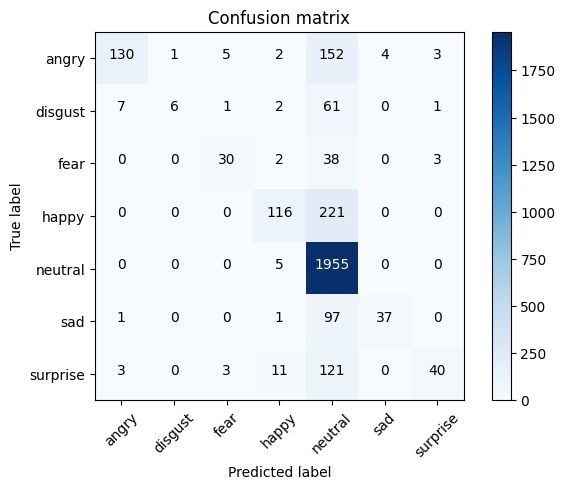

In [236]:
emo_keys = list(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'])

print('Test Set Accuracy =  {0:.4f}'.format(accuracy_score(emotion_label, y_pred_optuna)))
print('Test Set F-score =  {0:.4f}'.format(f1_score(emotion_label, y_pred_optuna, average='macro')))
print('Test Set Precision =  {0:.4f}'.format(precision_score(emotion_label, y_pred_optuna, average='macro')))
print('Test Set Recall =  {0:.4f}'.format(recall_score(emotion_label, y_pred_optuna, average='macro')))

emotion_labels.append(emotion_label)
y_pred_optunas.append(y_pred_optuna)
plot_confusion_matrix(confusion_matrix(emotion_label, y_pred_optuna), classes=emo_keys)

In [196]:
emotion_label

0          fear
1          fear
2          fear
3          fear
4          fear
         ...   
3055    neutral
3056    neutral
3057    neutral
3058    neutral
3059    neutral
Name: Emotion_x, Length: 3060, dtype: object

In [197]:
y_pred_optuna

array(['neutral', 'fear', 'angry', ..., 'neutral', 'neutral', 'neutral'],
      dtype='<U8')

In [198]:
y_pred_optuna[0]

'neutral'

In [237]:
true_index = []
false_index = []

for i in range(emotion_label.shape[0]):
  if emotion_label[i] == y_pred_optuna[i]:
    true_index.append(i)
  else:
    false_index.append(i)

In [155]:
pi_true = []
pi_false = []

In [156]:
result_1 = pi_values[0].index.isin(true_index)
result_indexes_1 = pi_values[0].index[result_1]
filtered_values_1 = pi_values[0].loc[result_indexes_1]
filtered_values_false_1 = pi_values[0].loc[~result_1]
pi_true.extend(list(filtered_values_1))
pi_false.extend(list(filtered_values_false_1))

In [178]:
result_2 = pi_values[1].index.isin(true_index)
result_indexes_2 = pi_values[1].index[result_2]
filtered_values_2 = pi_values[1].loc[result_indexes_2]
filtered_values_false_2 = pi_values[1].loc[~result_2]
pi_true.extend(list(filtered_values_2))
pi_false.extend(list(filtered_values_false_2))

In [200]:
result_3 = pi_values[2].index.isin(true_index)
result_indexes_3 = pi_values[2].index[result_3]
filtered_values_3 = pi_values[2].loc[result_indexes_3]
filtered_values_false_3 = pi_values[2].loc[~result_3]
pi_true.extend(list(filtered_values_3))
pi_false.extend(list(filtered_values_false_3))

In [220]:
result_4 = pi_values[3].index.isin(true_index)
result_indexes_4 = pi_values[3].index[result_4]
filtered_values_4 = pi_values[3].loc[result_indexes_4]
filtered_values_false_4 = pi_values[3].loc[~result_4]
pi_true.extend(list(filtered_values_4))
pi_false.extend(list(filtered_values_false_4))

In [238]:
result_5 = pi_values[4].index.isin(true_index)
result_indexes_5 = pi_values[4].index[result_5]
filtered_values_5 = pi_values[4].loc[result_indexes_5]
filtered_values_false_5 = pi_values[4].loc[~result_5]
pi_true.extend(list(filtered_values_5))
pi_false.extend(list(filtered_values_false_5))

In [248]:
import seaborn as sns

<ipython-input-264-c4ca2b7f7a59>:1: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.3`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=pi_true, label='Correct Classification', bw=0.3)
<ipython-input-264-c4ca2b7f7a59>:2: UserWarning: 

The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`.
Setting `bw_method=0.3`, but please see the docs for the new parameters
and update your code. This will become an error in seaborn v0.13.0.

  sns.kdeplot(data=pi_false, label='Misclassification', bw=0.3)


Text(0.5, 0, 'P')

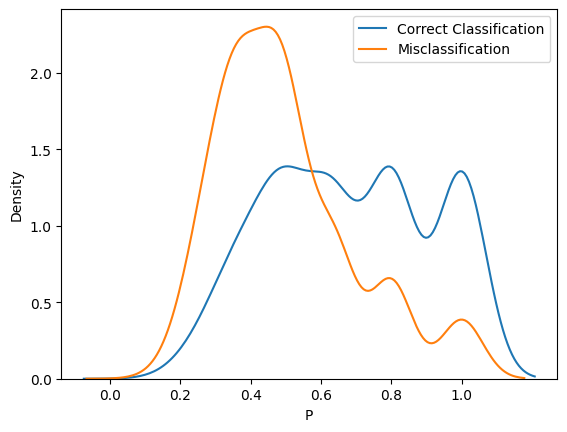

In [264]:
sns.kdeplot(data=pi_true, label='Correct Classification', bw=0.3)
sns.kdeplot(data=pi_false, label='Misclassification', bw=0.3)
plt.xticks([0.0,0.2,0.4,0.6,0.8,1.0])
plt.legend()
plt.xlabel('P')
# plt.title('정분류된 값의 KDE 분포')

[array([[ 190,    2,    1,    3,   84,    6,   10],
        [  20,   13,    1,    1,   40,    1,    2],
        [   8,    0,   49,    4,    8,    1,    4],
        [   9,    2,    1,  185,  134,    2,    4],
        [  54,    9,   10,   42, 1777,   34,   34],
        [   3,    0,    0,    1,   15,  117,    1],
        [   7,    0,    9,    6,   43,    2,  111]]),
 array([[ 213,    7,    3,    2,   58,    5,    9],
        [  21,   36,    2,    2,   16,    0,    1],
        [   7,    0,   51,    2,    5,    3,    6],
        [   6,    4,    2,  230,   80,    3,   12],
        [ 182,   66,   15,  103, 1510,   40,   44],
        [   3,    0,    0,    0,   23,  110,    0],
        [  14,    1,   10,    9,   39,    0,  105]]),
 array([[ 180,    5,    3,    2,   97,    3,    7],
        [   9,   25,    6,    1,   33,    0,    4],
        [   7,    0,   49,    2,    7,    2,    6],
        [   7,    0,    5,  162,  149,    1,   12],
        [  17,    0,    5,   59, 1864,    7,    8],
        